## Importando bibliotecas

In [1]:
# pacotes para visualizar explorar os dados
import pandas as pd
import numpy as np
from scipy import stats

# pacotes para plotar gráficos
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# ignorar avisos
import warnings

warnings.filterwarnings("ignore")

# scalers
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
    Normalizer,
    QuantileTransformer,
    PowerTransformer,
)

# encoders para variáveis categóricas
import category_encoders as ce

# scikit-learn para rodar modelos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from collections import Counter


# importando algortimos de modelos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier, plot_importance
import xgboost as xgb  # instanciar como 'xgb.XGBClassifier()
import catboost
from sklearn.naive_bayes import GaussianNB

# metricas para avaliar desempenho do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    mean_squared_error,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    plot_roc_curve,
    log_loss,
    roc_curve,
    log_loss,
)
from sklearn.metrics import SCORERS

metricas = SCORERS.keys()

# balancemento
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# validação
from sklearn.model_selection import KFold, StratifiedKFold

# 1parametro
from sklearn.model_selection import learning_curve, cross_validate  # para plotar
from sklearn.model_selection import validation_curve, cross_val_score  # calculando
from sklearn.model_selection import ParameterGrid

# mais de um parametro
from sklearn.model_selection import ParameterSampler, GridSearchCV, RandomizedSearchCV


# auto indexação
%load_ext lab_black

## Entendendo o dataset

In [2]:
adult = pd.read_csv("data/adult.csv")
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
def EDA(df):
    eda_df = {}
    eda_df["Amount_NaN"] = df.isnull().sum()
    eda_df["%_NaN"] = df.isnull().mean().round(2)
    eda_df["DType"] = df.dtypes
    eda_df["Amount_Data"] = df.count()
    eda_df["Amount_Unique"] = df.apply(lambda x: len(x.unique()))
    eda_df["Mean"] = np.round(df.mean(), 2)
    eda_df["Median"] = np.round(df.median(), 2)
    eda_df["Max"] = df.max()
    eda_df["Min"] = df.min()
    eda_df["STD"] = np.round(df.std(), 2)

    eda_df = pd.DataFrame(eda_df)

    return eda_df

In [4]:
EDA(adult)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Median,Max,Min,STD
age,0,0.0,int64,48842,74,38.64,37.0,90,17,13.71
capital-gain,0,0.0,int64,48842,123,1079.07,0.0,99999,0,7452.02
capital-loss,0,0.0,int64,48842,99,87.50,0.0,4356,0,403.00
education,0,0.0,object,48842,16,NaN,NaN,Some-college,10th,NaN
educational-num,0,0.0,int64,48842,16,10.08,10.0,16,1,2.57
fnlwgt,0,0.0,int64,48842,28523,189664.13,178144.5,1490400,12285,105604.03
gender,0,0.0,object,48842,2,NaN,NaN,Male,Female,NaN
hours-per-week,0,0.0,int64,48842,96,40.42,40.0,99,1,12.39
income,0,0.0,object,48842,2,NaN,NaN,>50K,<=50K,NaN
marital-status,0,0.0,object,48842,7,NaN,NaN,Widowed,Divorced,NaN


In [5]:
# ajustando os nomes para poder trabalhar melhor
adult.rename(
    mapper={
        "capital-gain": "capital_gain",
        "capital-loss": "capital_loss",
        "educational-num": "educational_num",
        "hours-per-week": "hours_per_week",
        "marital-status": "marital_status",
        "native-country": "native_country",
    },
    axis=1,
    inplace=True,
)
adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [6]:
# eliminando uma feature redundante, pois esta nos entrega a mesma informação que education
del adult["educational_num"]

## FEATURES NUMÉRICAS

#### lidando com outliers

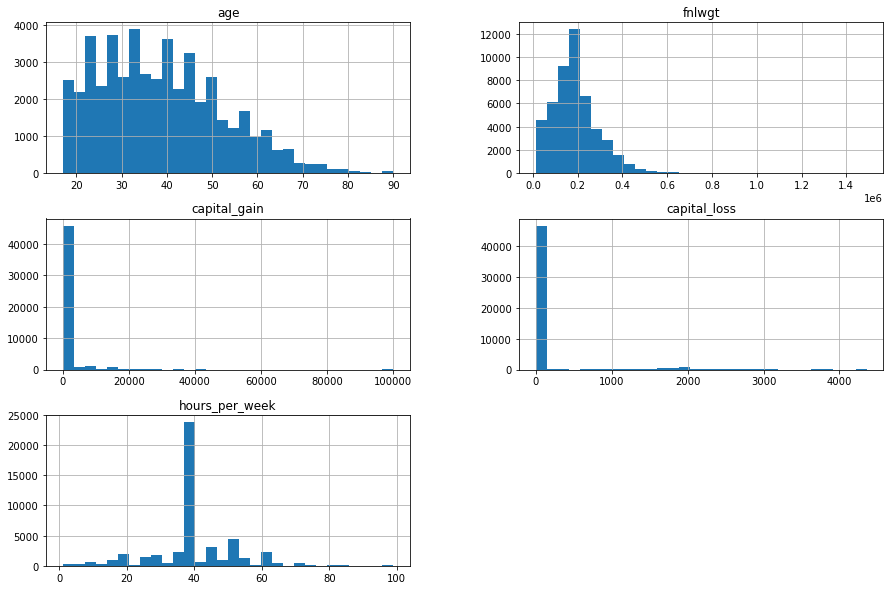

In [7]:
# olhada geral sobre as distribuições
adult.hist(figsize=(15, 10), bins=30)
plt.show()

In [8]:
antes = len(adult)
agemean = adult.age.mean()
fnlwgtmean = adult.fnlwgt.mean()
cpgmean = adult.capital_gain.mean()
hpwmean = adult.hours_per_week.mean()
agestd = adult.age.std()
fnlwgtstd = adult.fnlwgt.std()
cpgstd = adult.capital_gain.std()
hpwstd = adult.hours_per_week.std()
cplthreshold = 2000

adult = adult[adult.age < agemean + 3 * agestd]
adult = adult[adult.fnlwgt < fnlwgtmean + 3 * fnlwgtstd]
adult = adult[adult.capital_gain < cpgmean + 3 * cpgstd]
adult = adult[adult.capital_loss < cplthreshold]
adult = adult[
    (adult.hours_per_week < hpwmean + 3 * hpwstd)
    & (adult.hours_per_week > hpwmean - 3 * hpwstd)
]

depois = len(adult)
print(f"{round(1 - (depois/antes), 3)}% dos dados foram dropados como outliers.")

0.044% dos dados foram dropados como outliers.


#### Vamos verificar as distribuições das features e como elas se alteram com algumas transformações

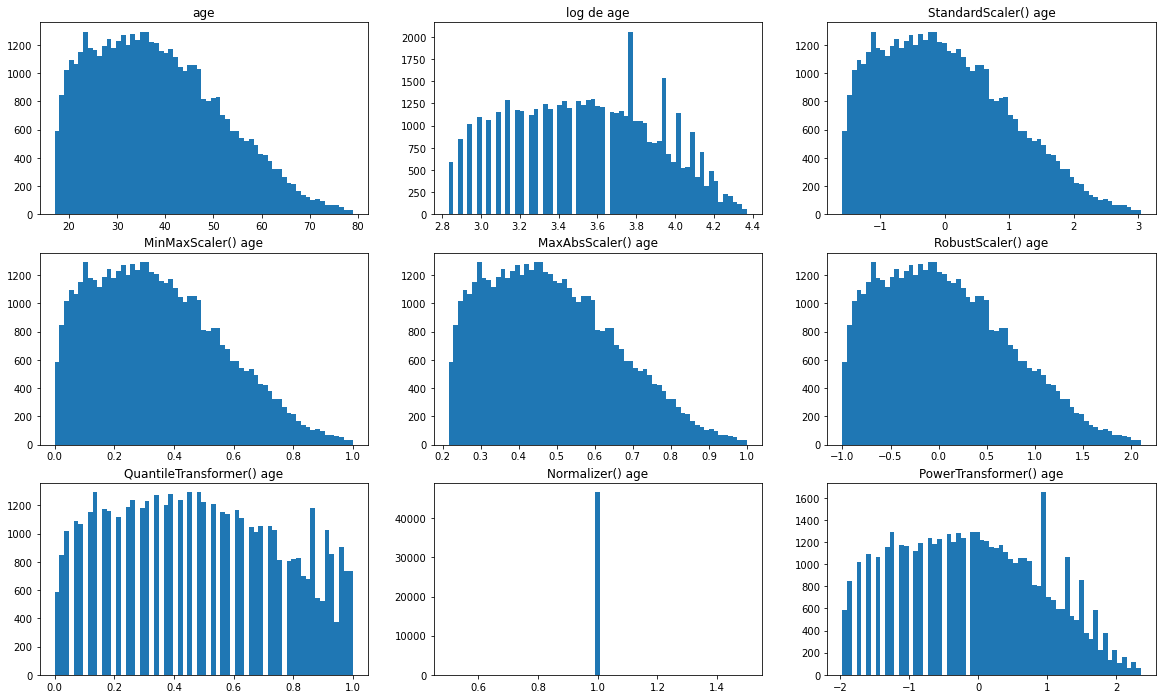

In [9]:
## %%time
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    Normalizer(),
    PowerTransformer(),
]

contador = 0
for row in list(range(3)):
    for col in list(range(3)):
        if (row == 0) & (col == 0):
            axs[row, col].hist(adult["age"], bins=63)
            axs[row, col].set_title("age")

        elif (row == 0) & (col == 1):
            axs[row, col].hist(np.log(adult["age"]), bins=63)
            axs[row, col].set_title("log de age")

        else:
            axs[row, col].hist(
                scaler_list[contador].fit_transform(
                    np.array(adult["age"]).reshape(-1, 1)
                ),
                bins=63,
            )
            axs[row, col].set_title(str(scaler_list[contador]) + " age")
            contador += 1

plt.show()

age_skew_list = [stats.skew(adult["age"]), stats.skew(np.log(adult["age"])) * (-1)]
for scaler in scaler_list:
    age_skew_list.append(
        stats.skew(scaler.fit_transform(np.array(adult["age"]).reshape(-1, 1))).round(5)
    )

a = ["sem scaler", "log"]
for scaler in scaler_list:
    a.append(str(scaler))

skewness1 = pd.DataFrame({"age": a, "age_skew": np.abs(age_skew_list)}).sort_values(
    by="age_skew"
)
skewness1["age_skew"] = skewness1["age_skew"].astype(float)

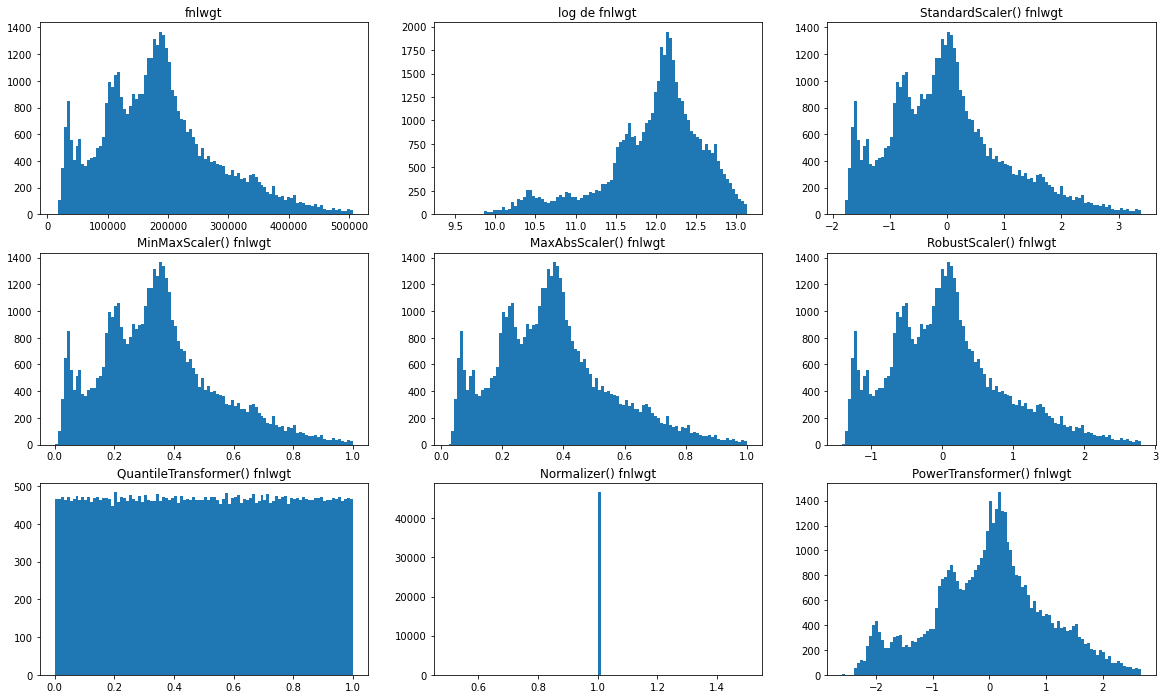

Wall time: 3.29 s


In [10]:
%%time
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    Normalizer(),
    PowerTransformer(),
]

contador = 0
for row in list(range(3)):
    for col in list(range(3)):
        if (row == 0) & (col == 0):
            axs[row, col].hist(adult["fnlwgt"], bins = 100)
            axs[row, col].set_title("fnlwgt")

        elif (row == 0) & (col == 1):
            axs[row, col].hist(np.log(adult["fnlwgt"]), bins = 100)
            axs[row, col].set_title("log de fnlwgt")

        else:
            axs[row, col].hist(scaler_list[contador].fit_transform(np.array(adult["fnlwgt"]).reshape(-1, 1)), bins = 100)
            axs[row, col].set_title(str(scaler_list[contador]) + " fnlwgt")
            contador += 1

plt.show()

fnlwgt_skew_list = [stats.skew(adult['fnlwgt']), stats.skew(np.log(adult["fnlwgt"])) * (-1)]
for scaler in scaler_list:
    fnlwgt_skew_list.append(stats.skew(scaler.fit_transform(np.array(adult["fnlwgt"]).reshape(-1, 1))).round(5))

b = ['sem scaler', "log"]
for scaler in scaler_list:
    b.append(str(scaler))

skewness2 = pd.DataFrame({"fnlwgt": b, "fnlwgt_skew": np.abs(fnlwgt_skew_list)}).sort_values(by="fnlwgt_skew")
skewness2['fnlwgt_skew'] = skewness2['fnlwgt_skew'].astype(float)

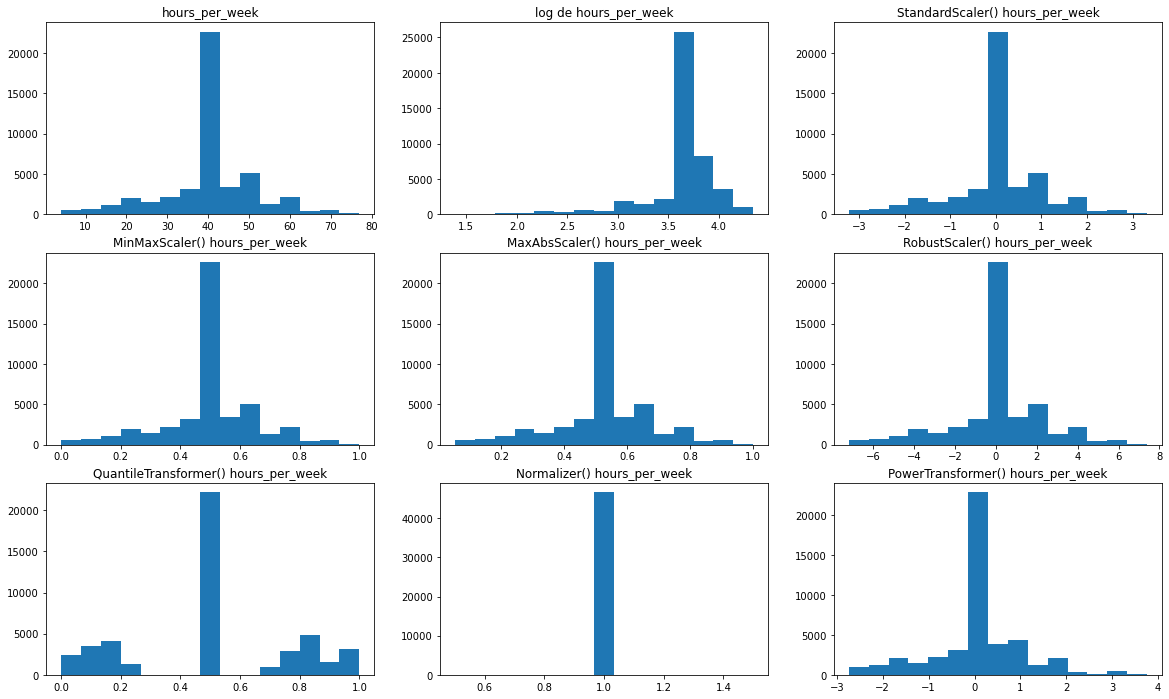

Wall time: 1.58 s


In [11]:
%%time
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    Normalizer(),
    PowerTransformer(),
]

contador = 0
for row in list(range(3)):
    for col in list(range(3)):
        if (row == 0) & (col == 0):
            axs[row, col].hist(adult["hours_per_week"], bins=15)
            axs[row, col].set_title("hours_per_week")

        elif (row == 0) & (col == 1):
            axs[row, col].hist(np.log(adult["hours_per_week"]), bins=15)
            axs[row, col].set_title("log de hours_per_week")

        else:
            axs[row, col].hist(
                scaler_list[contador].fit_transform(
                    np.array(adult["hours_per_week"]).reshape(-1, 1)
                ),
                bins=15
            )
            axs[row, col].set_title(str(scaler_list[contador]) + " hours_per_week")
            contador += 1

plt.show()

hours_pw_skew_list = [stats.skew(adult['hours_per_week']), stats.skew(np.log(adult["hours_per_week"])) * (-1)]
for scaler in scaler_list:
    hours_pw_skew_list.append(stats.skew(scaler.fit_transform(np.array(adult["hours_per_week"]).reshape(-1, 1))).round(5))

c = ['sem scaler', "log"]
for scaler in scaler_list:
    c.append(str(scaler))

skewness3 = pd.DataFrame({"hours_pw": c, "hours_pw_skew": np.abs(hours_pw_skew_list)}).sort_values(by="hours_pw_skew")
skewness3['hours_pw_skew'] = skewness3['hours_pw_skew'].astype(float)

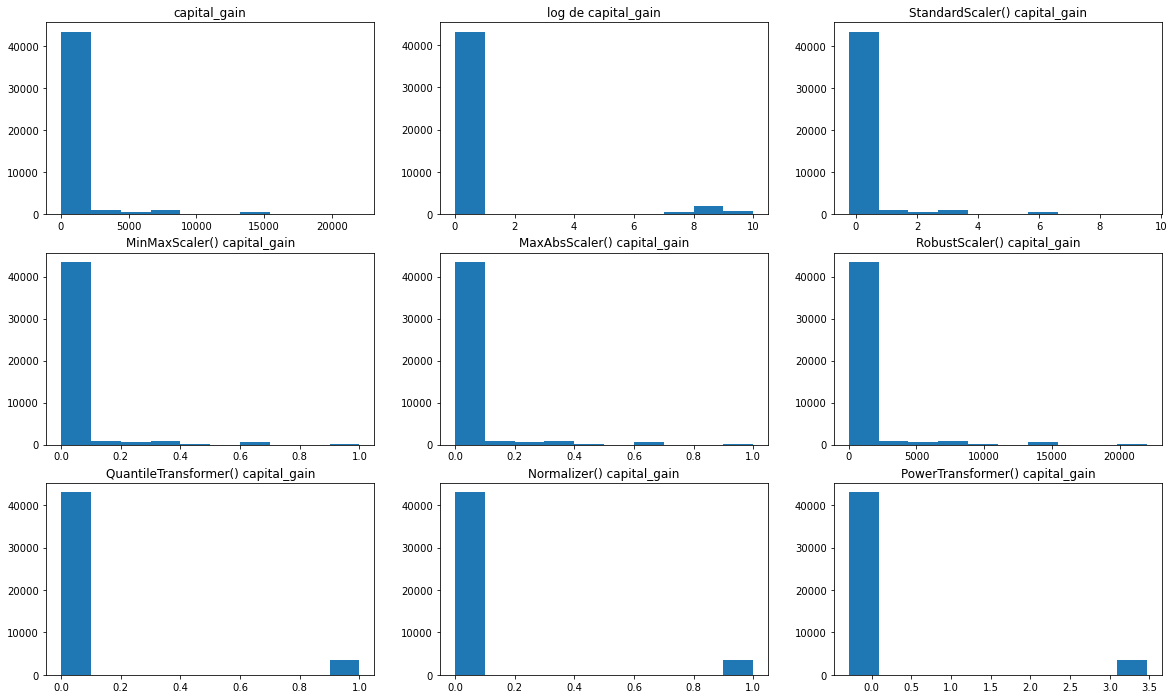

Wall time: 1.52 s


In [12]:
%%time
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    Normalizer(),
    PowerTransformer(),
]

contador = 0
for row in list(range(3)):
    for col in list(range(3)):
        if (row == 0) & (col == 0):
            axs[row, col].hist(adult["capital_gain"], bins=10)
            axs[row, col].set_title("capital_gain")

        elif (row == 0) & (col == 1):
            axs[row, col].hist(np.log(adult["capital_gain"]+1), bins=10)
            axs[row, col].set_title("log de capital_gain")

        else:
            axs[row, col].hist(
                scaler_list[contador].fit_transform(
                    np.array(adult["capital_gain"]).reshape(-1, 1)
                ),
                bins=10,
            )
            axs[row, col].set_title(str(scaler_list[contador]) + " capital_gain")
            contador += 1

plt.show()

capital_gain_skew_list = [stats.skew(adult['capital_gain']), stats.skew(np.log(adult["capital_gain"]+1)) * (-1)]
for scaler in scaler_list:
    capital_gain_skew_list.append(stats.skew(scaler.fit_transform(np.array(adult["capital_gain"]).reshape(-1, 1))).round(5))

d = ['sem scaler', "log"]
for scaler in scaler_list:
    d.append(str(scaler))

skewness4 = pd.DataFrame({"capital_gain": d, "cg_skew": np.abs(capital_gain_skew_list)}).sort_values(by="cg_skew")
skewness4['cg_skew'] = skewness4['cg_skew'].astype(float)

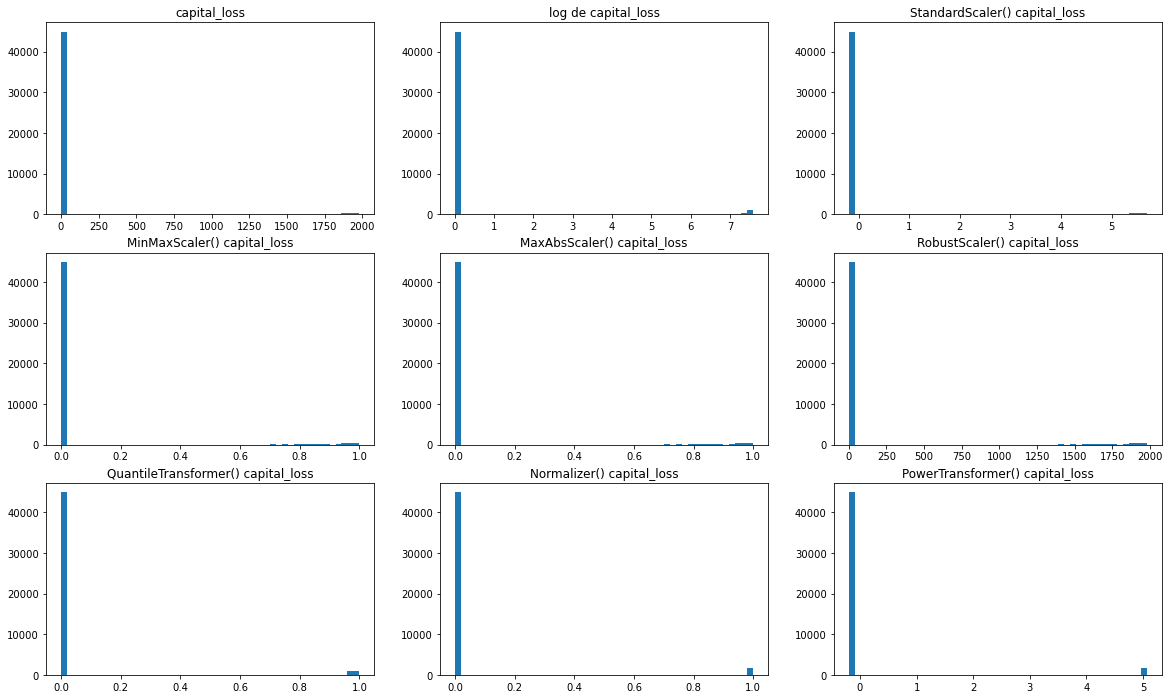

Wall time: 2.07 s


In [13]:
%%time
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    Normalizer(),
    PowerTransformer(),
]

contador = 0
for row in list(range(3)):
    for col in list(range(3)):
        if (row == 0) & (col == 0):
            axs[row, col].hist(adult["capital_loss"], bins=50)
            axs[row, col].set_title("capital_loss")

        elif (row == 0) & (col == 1):
            axs[row, col].hist(np.log(adult["capital_loss"]+1), bins=50)
            axs[row, col].set_title("log de capital_loss")

        else:
            axs[row, col].hist(
                scaler_list[contador].fit_transform(
                    np.array(adult["capital_loss"]).reshape(-1, 1)
                ),
                bins=50,
            )
            axs[row, col].set_title(str(scaler_list[contador]) + " capital_loss")
            contador += 1

plt.show()

capital_loss_skew_list = [stats.skew(adult['capital_loss']), stats.skew(np.log(adult["capital_loss"]+1)) * (-1)]
for scaler in scaler_list:
    capital_loss_skew_list.append(stats.skew(scaler.fit_transform(np.array(adult["capital_loss"]).reshape(-1, 1))).round(5))

e = ['sem scaler', "log"]
for scaler in scaler_list:
    e.append(str(scaler))

skewness5 = pd.DataFrame({"capital_loss": e, "cl_skew": np.abs(capital_loss_skew_list)}).sort_values(by="cl_skew")
skewness5['cl_skew'] = skewness5['cl_skew'].astype(float)

#### analisando assimetrias com diferentes transformações

In [14]:
skewness = pd.concat(
    [skewness1, skewness2, skewness3, skewness4, skewness5], axis=1, sort=True
)
skewness.drop(index=7, inplace=True)

print(
    "O scaler que mais minimiza o skew da distribuição de age é: ",
    skewness[skewness.age_skew == skewness.age_skew.min()].age.values,
)
print(
    "O scaler que mais minimiza o skew da distribuição de fnlwgt é: ",
    skewness[skewness.fnlwgt_skew == skewness.fnlwgt_skew.min()].fnlwgt.values,
)
print(
    "O scaler que mais minimiza o skew da distribuição de hours_pw é: ",
    skewness[skewness.hours_pw_skew == skewness.hours_pw_skew.min()].hours_pw.values,
)
print(
    "O scaler que mais minimiza o skew da distribuição de capital_gain é: ",
    skewness[skewness.cg_skew == skewness.cg_skew.min()].capital_gain.values,
)
print(
    "O scaler que mais minimiza o skew da distribuição de capital_loss é: ",
    skewness[skewness.cl_skew == skewness.cl_skew.min()].capital_loss.values,
)

skewness

O scaler que mais minimiza o skew da distribuição de age é:  ['QuantileTransformer()']
O scaler que mais minimiza o skew da distribuição de fnlwgt é:  ['QuantileTransformer()']
O scaler que mais minimiza o skew da distribuição de hours_pw é:  ['QuantileTransformer()']
O scaler que mais minimiza o skew da distribuição de capital_gain é:  ['PowerTransformer()']
O scaler que mais minimiza o skew da distribuição de capital_loss é:  ['PowerTransformer()']


,age,age_skew,fnlwgt,fnlwgt_skew,hours_pw,hours_pw_skew,capital_gain,cg_skew,capital_loss,cl_skew
0,sem scaler,0.481267,sem scaler,0.635493,sem scaler,0.353801,sem scaler,5.097882,sem scaler,5.005118
1,log,0.153734,log,0.944177,log,2.275822,log,3.226253,log,4.881211
2,StandardScaler(),0.481270,StandardScaler(),0.635490,StandardScaler(),0.353800,StandardScaler(),5.097880,StandardScaler(),5.005120
3,MinMaxScaler(),0.481270,MinMaxScaler(),0.635490,MinMaxScaler(),0.353800,MinMaxScaler(),5.097880,MinMaxScaler(),5.005120
4,MaxAbsScaler(),0.481270,MaxAbsScaler(),0.635490,MaxAbsScaler(),0.353800,MaxAbsScaler(),5.097880,MaxAbsScaler(),5.005120
5,RobustScaler(),0.481270,RobustScaler(),0.635490,RobustScaler(),0.353800,RobustScaler(),5.097880,RobustScaler(),5.005120
6,QuantileTransformer(),0.001570,QuantileTransformer(),0.000020,QuantileTransformer(),0.026310,QuantileTransformer(),3.185840,QuantileTransformer(),4.875200
8,PowerTransformer(),0.018740,PowerTransformer(),0.035160,PowerTransformer(),0.109340,PowerTransformer(),3.182630,PowerTransformer(),4.874220


#### entendendo a correlação das features numéricas com a target income

In [ ]:
# transformando a target em binária 0,1
adult.income = adult.income.map({"<=50K": 0, ">50K": 1})

In [ ]:
sns.set(font_scale=1.0)
plt.figure(figsize=(5, 5))

# plotando o heatmap padrão sem alterar nada
sns.heatmap(
    np.abs(adult.corr().iloc[:6, :6]),
    cbar=True,
    annot=True,
    square=True,
    fmt=".3f",
    cmap="BuPu",
    annot_kws={"size": 10},
)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("CORRELAÇÕES")
plt.show()

"""==========================================================="""

# loop com plotagem de heatmaps para cada scaler e montagem do df comparativo
adult_copy = adult.copy()

scaler_list = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(),
    PowerTransformer(),
]

correlacoes = pd.DataFrame(
    {"feature": adult_copy.corr().columns[:5].tolist()}
)  # criando dataframe comparativo
correlacoes["puro"] = np.abs(adult_copy.corr()).income[:5].tolist()

for scaler in scaler_list:
    adult_copy["scaled_age"] = scaler.fit_transform(
        np.array(adult_copy.age).reshape(-1, 1)
    )  # coluna com feature age transformada
    adult_copy["scaled_fnlwgt"] = scaler.fit_transform(
        np.array(adult_copy.fnlwgt).reshape(-1, 1)
    )  # coluna com feature fnlwgt transformada
    adult_copy["scaled_capital_gain"] = scaler.fit_transform(
        np.array(adult_copy.capital_gain).reshape(-1, 1)
    )  # coluna com feature capital_gain transformada
    adult_copy["scaled_capital_loss"] = scaler.fit_transform(
        np.array(adult_copy.capital_loss).reshape(-1, 1)
    )  # coluna com feature capital_loss transformada
    adult_copy["scaled_hours_per_week"] = scaler.fit_transform(
        np.array(adult_copy.hours_per_week).reshape(-1, 1)
    )  # coluna com feature hours_per_week transformada

    # plotando heatmap pós transformação
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        np.abs(adult_copy.corr().iloc[5:, 5:]),
        cbar=True,
        annot=True,
        square=True,
        fmt=".3f",
        cmap="BuPu",
        annot_kws={"size": 10},
    )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("CORRELAÇÃO " + str(scaler) + ")")
    plt.show()

    correlacoes[str(scaler)] = (
        np.abs(adult_copy.corr()).income[6:].tolist()
    )  # adicionando coluna ao dataframe comparativo

# ajustando df comparativo de correlações
correlacoes = correlacoes.T
correlacoes.columns = adult.corr().columns[:-1]
correlacoes = correlacoes.iloc[1:, :]
correlacoes


# retornando os melhores scalers
print(
    "A transformação que mais faz a correlação de age com a target aumentar é:",
    correlacoes[correlacoes.age == correlacoes.age.max()].index,
)
print(
    "A transformação que mais faz a correlação de fnlwgt com a target aumentar é:",
    correlacoes[correlacoes.fnlwgt == correlacoes.fnlwgt.max()].index,
)
print(
    "A transformação que mais faz a correlação de capital_gain com a target aumentar é:",
    correlacoes[correlacoes.capital_gain == correlacoes.capital_gain.max()].index,
)
print(
    "A transformação que mais faz a correlação de capital_loss com a target aumentar é:",
    correlacoes[correlacoes.capital_loss == correlacoes.capital_loss.max()].index,
)
print(
    "A transformação que mais faz a correlação de hours_per_week com a target aumentar é:",
    correlacoes[correlacoes.hours_per_week == correlacoes.hours_per_week.max()].index,
)
correlacoes

#### outra forma de ver como as variáveis se correlacionam com as instancias de income=0 e income=1

In [ ]:
scan_incomes1 = adult.groupby(by="income").median()


def most_frequent(series):
    return series.value_counts().index[0]


scan_incomes2 = adult.groupby("income")[
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native_country",
].agg(most_frequent)

scan_incomes = scan_incomes1.merge(scan_incomes2, on="income", how="left")
scan_incomes

## FEATURES CATEGÓRICAS - Testando modelos com encoders

In [ ]:
# para ver melhor os dataframes gerados
pd.options.display.max_columns = None

In [ ]:
# Criando lista de possíveis encoders para variaveis nominais
encoders = [
    ce.BinaryEncoder(),
    ce.CatBoostEncoder(),
    ce.GLMMEncoder(),
    ce.JamesSteinEncoder(),
    ce.MEstimateEncoder(),
    ce.OneHotEncoder(),
    ce.TargetEncoder(),
    ce.WOEEncoder(),
]

scalers = [StandardScaler(), QuantileTransformer(), PowerTransformer()]

# Criando uma lista de modelos classificadores a serem testados
classifiers = [
    LGBMClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    BaggingClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
]

In [ ]:
# SPLITS
X = adult.drop(columns=["income"])
y = adult.income
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

In [ ]:
# separando em dois tipos de feature
cat_nominal_features = [
    "workclass",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native_country",
]

cat_ordinal_features = ["education"]

numeric_features = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]

##### loop de todos os defaults com os possíveis encoders e scalers

In [ ]:
%%time 

#criando listas de métricas que virarão colunas num dataframe
auc_treino = []
auc_teste = []
f1_treino = []
f1_teste = []
precisao_treino = []
precisao_teste = []
recall_treino = []
recall_teste =[]
acuracia_treino = []
acuracia_teste = []
encoder_list = []
modelo = []
scalers_list = []

#finalmente o loop que fitará todos os modelos dos quais traremos as previsões
i=1
for clf in classifiers:
    for scaler in scalers:
        for encoder in encoders:
            try:
                #tratamento que será dado a cada tipo
                cat_nominal_transformer = Pipeline(steps=[('encoder', encoder)])
                cat_ordinal_transformer = Pipeline(steps=[('encoder', ce.OrdinalEncoder())])
                numeric_transformer = Pipeline(steps=[('scaler', scaler)])
                
                #preprocessamento conjunto
                preprocessor = ColumnTransformer(transformers = [('nencoder', cat_nominal_transformer, cat_nominal_features),
                                                                 ('oencoder', cat_ordinal_transformer, cat_ordinal_features),
                                                                 ('scaler', numeric_transformer, numeric_features)])
                
                pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)]) #instancia
                pipe.fit(X_train, y_train) # ajusta
                
                y_pred_treino = pipe.predict(X_train) #prevê 0 ou 1 no treino
                y_pred_teste = pipe.predict(X_test) #prevê 0 ou 1 no teste
                y_pred_proba_treino = pipe.predict_proba(X_train)[::,1] #prevê probabilidade de 0 e 1 no treino
                y_pred_proba_teste = pipe.predict_proba(X_test)[::,1]  #prevê probabilidade de 0 e 1 no teste
                
                #salvando métricas do modelo em listas (armazenar os resultados de treino para verificar overfitting)
                modelo.append(clf)
                encoder_list.append(encoder)
                scalers_list.append(scaler)
                
                auc_treino.append(roc_auc_score(y_train, y_pred_proba_treino))
                auc_teste.append(roc_auc_score(y_test, y_pred_proba_teste))
                
                f1_treino.append(f1_score(y_train, y_pred_treino))
                f1_teste.append(f1_score(y_test, y_pred_teste)) 
                
                acuracia_treino.append(accuracy_score(y_train, y_pred_treino))
                acuracia_teste.append(accuracy_score(y_test, y_pred_teste))
                
                precisao_treino.append(precision_score(y_train, y_pred_treino))
                precisao_teste.append(precision_score(y_test, y_pred_teste))
                
                recall_treino.append(recall_score(y_train, y_pred_treino))
                recall_teste.append(recall_score(y_test, y_pred_teste))
            
            #caso tivermos algum erro o loop seguirá e enviará o aviso 
            except:
                print('O modelo de ', clf, ' com', encoder, 'com', scaler, ' não rodou!')
                
            #para termos noção do andamento do loop enquanto ele roda
            if i in np.arange(24,217,24):
                print(100*(i/216), '%rodado')
            i +=1
            
 #criando dataframe comparativo    
desempenho = pd.DataFrame({'modelo':modelo, 
                           'encoder': encoder_list,
                           'scaler': scalers_list,
                           'auc_treino': auc_treino,
                           'auc_teste': auc_teste,
                           'f1_treino':f1_treino,
                           'f1_teste': f1_teste,
                           'precisao_treino': precisao_treino,
                           'precisao_teste': precisao_teste,
                           'recall_treino': recall_treino, 
                           'recall_teste': recall_teste,
                           'acuracia_treino': acuracia_treino,
                           'acuracia_teste': acuracia_teste}).sort_values(by=['auc_teste', 'auc_treino', 'f1_teste', 'f1_treino'], ascending = False)
desempenho.head()

##### vamos ver qual a melhor combinação encoder/scaler para cada algoritmo

In [ ]:
desempenho["modelo_name"] = desempenho.modelo.astype("str")

a = desempenho[desempenho.modelo_name == "LGBMClassifier()"].iloc[0, 1]
b = desempenho[desempenho.modelo_name == "GradientBoostingClassifier()"].iloc[0, 1]
c = desempenho[desempenho.modelo_name == "AdaBoostClassifier()"].iloc[0, 1]
d = desempenho[desempenho.modelo_name == "RandomForestClassifier()"].iloc[0, 1]
e = desempenho[desempenho.modelo_name == "BaggingClassifier()"].iloc[0, 1]
f = desempenho[desempenho.modelo_name == "LogisticRegression()"].iloc[0, 1]
g = desempenho[desempenho.modelo_name == "KNeighborsClassifier()"].iloc[0, 1]
h = desempenho[desempenho.modelo_name == "GaussianNB()"].iloc[0, 1]
i = desempenho[desempenho.modelo_name == "DecisionTreeClassifier()"].iloc[0, 1]

j = desempenho[desempenho.modelo_name == "LGBMClassifier()"].iloc[0, 2]
k = desempenho[desempenho.modelo_name == "GradientBoostingClassifier()"].iloc[0, 2]
l = desempenho[desempenho.modelo_name == "AdaBoostClassifier()"].iloc[0, 2]
m = desempenho[desempenho.modelo_name == "RandomForestClassifier()"].iloc[0, 2]
n = desempenho[desempenho.modelo_name == "BaggingClassifier()"].iloc[0, 2]
o = desempenho[desempenho.modelo_name == "LogisticRegression()"].iloc[0, 2]
p = desempenho[desempenho.modelo_name == "KNeighborsClassifier()"].iloc[0, 2]
q = desempenho[desempenho.modelo_name == "GaussianNB()"].iloc[0, 2]
r = desempenho[desempenho.modelo_name == "DecisionTreeClassifier()"].iloc[0, 2]

melhores_encoders_default = pd.DataFrame(
    {
        "modelo": desempenho.modelo_name.unique().tolist(),
        "melhor_encoder": [a, b, c, d, e, f, g, h, i],
        "melhor_scaler": [j, k, l, m, n, o, p, q, r],
    }
)

melhores_encoders_default

#### plotando a curva ROC dos melhores modelos(scoring AUC)

In [ ]:
%%time
plt.figure(figsize=(10, 10))

for i in np.arange(0,9,1):
    cat_nominal_transformer = Pipeline(steps=[('nencoder', melhores_encoders_default.iloc[i,1])])
    cat_ordinal_transformer = Pipeline(steps=[('oencoder', ce.OrdinalEncoder())])
    numeric_transformer = Pipeline(steps=[('scaler', melhores_encoders_default.iloc[i,2])])
                
    #preprocessamento conjunto
    preprocessor = ColumnTransformer(
        transformers=[
            ('nencoder', cat_nominal_transformer, cat_nominal_features),
            ('oencoder', cat_ordinal_transformer, cat_ordinal_features),
            ("scaler", numeric_transformer, numeric_features)
        ]
    )

    pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", classifiers[i])]
    )
    print(classifiers[i])

    pipe.fit(X_train, y_train)
    y_pred_proba = pipe.predict_proba(X_test)[::, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=str(melhores_encoders_default.modelo[i])+ " auc="+ str(roc_auc_score(y_test, y_pred_proba)))

    plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
    plt.legend(loc="best")

plt.show()

#### definindo os pipes para cada classificador


In [ ]:
cat_ordinal_transformer = Pipeline(steps=[("encoder", ce.OrdinalEncoder())])

# LGBM
cat_nominal_transformer1 = Pipeline(steps=[("encoder", ce.OneHotEncoder())])
numeric_transformer1 = Pipeline(steps=[("scaler", QuantileTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("nencoder", cat_nominal_transformer1, cat_nominal_features),
        ("oencoder", cat_ordinal_transformer, cat_ordinal_features),
        ("scaler", numeric_transformer1, numeric_features),
    ]
)
lgbm_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LGBMClassifier())]
)

# RandomForest
cat_nominal_transformer2 = Pipeline(steps=[("encoder", ce.CatBoostEncoder())])
numeric_transformer2 = Pipeline(steps=[("scaler", QuantileTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("nencoder", cat_nominal_transformer2, cat_nominal_features),
        ("oencoder", cat_ordinal_transformer, cat_ordinal_features),
        ("scaler", numeric_transformer2, numeric_features),
    ]
)
rf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

# LogisticRegression
cat_nominal_transformer3 = Pipeline(steps=[("encoder", ce.MEstimateEncoder())])
numeric_transformer3 = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("nencoder", cat_nominal_transformer3, cat_nominal_features),
        ("oencoder", cat_ordinal_transformer, cat_ordinal_features),
        ("scaler", numeric_transformer3, numeric_features),
    ]
)
lgr_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

# KNeighbors
cat_nominal_transformer4 = Pipeline(steps=[("encoder", ce.WOEEncoder())])
numeric_transformer4 = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("nencoder", cat_nominal_transformer4, cat_nominal_features),
        ("oencoder", cat_ordinal_transformer, cat_ordinal_features),
        ("scaler", numeric_transformer4, numeric_features),
    ]
)
knn_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

# GaussianNB
cat_nominal_transformer5 = Pipeline(steps=[("encoder", ce.CatBoostEncoder())])
numeric_transformer5 = Pipeline(steps=[("scaler", QuantileTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("nencoder", cat_nominal_transformer5, cat_nominal_features),
        ("oencoder", cat_ordinal_transformer, cat_ordinal_features),
        ("scaler", numeric_transformer5, numeric_features),
    ]
)
gnb_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GaussianNB())]
)

#### Learning Curves para saber melhores tamanhos de amostras que podem alterar desempenho


In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator=lgbm_pipe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title("LGBM Learning Curve")
plt.xlabel("Nº de dados")
plt.ylabel("AUC Score")
plt.grid()
# plt.ylim((0,1))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator=rf_pipe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title("Random Forest Learning Curve")
plt.xlabel("Nº de dados")
plt.ylabel("AUC Score")
plt.grid()
# plt.ylim((0,1))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator=lgr_pipe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title("Logistic Regression Learning Curve")
plt.xlabel("Nº de dados")
plt.ylabel("AUC Score")
plt.grid()
# plt.ylim((0,1))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator=knn_pipe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title("K Nearest Neighbors Learning Curve")
plt.xlabel("Nº de dados")
plt.ylabel("AUC Score")
plt.grid()
# plt.ylim((0,1))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator=gnb_pipe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title("Gaussian Naive-Bayes Learning Curve")
plt.xlabel("Nº de dados")
plt.ylabel("AUC Score")
plt.grid()
# plt.ylim((0,1))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

#### Knn e RandomForest 'overfitam'

parece que pelo menos 30mil samples o desempenho não altera tanto

## Balanceamento de Dados

o indicador auc parece bom, porém o f1-score que também é importante está muito precário, vamos ver se um balanceamento da target pode ajudar

In [ ]:
original = Counter(y)  # distribuição da target antes de balancear
print(original)

# instanciando métodos de balanceamento
undersample = RandomUnderSampler(
    sampling_strategy=1
)  # eliminando aleatoriamente dados da target da classe majoritária
oversample = RandomOverSampler(
    sampling_strategy=1
)  # sintetizando aleatoriamente dados da target da classe minoritária

X_under, y_under = undersample.fit_resample(X, y)  # refazendo o dataset
X_over, y_over = oversample.fit_resample(X, y)

targetunder = Counter(y_under)  # vendo a contagem da target com undersampling
targetover = Counter(y_over)  # venod a contagem da target com oversampling

print("\nUnderSampler: ", targetunder)
print("\nOverSampler: ", targetover)

In [ ]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=7, stratify=y_under, shuffle=True
)

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over, y_over, test_size=0.2, random_state=7, stratify=y_over, shuffle=True
)

print(
    "under: ",
    X_train_under.shape,
    X_test_under.shape,
    y_train_under.shape,
    y_test_under.shape,
    "\n",
)
print(
    "over: ",
    X_train_over.shape,
    X_test_over.shape,
    y_train_over.shape,
    y_test_over.shape,
)

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
models = [lgbm_pipe, rf_pipe, lgr_pipe, knn_pipe, gnb_pipe]

sor_mean = []
sor_std = []
sun_mean = []
sun_std = []
sov_mean = []
sov_std = []

for m in models:
    scoreoriginal = cross_val_score(
        estimator=m, X=X_train, y=y_train, scoring="f1", cv=skf
    )

    sor_mean.append(scoreoriginal.mean())
    sor_std.append(scoreoriginal.std())

    scoreunder = cross_val_score(
        estimator=m, X=X_train_under, y=y_train_under, scoring="f1", cv=skf
    )

    sun_mean.append(scoreunder.mean())
    sun_std.append(scoreunder.std())

    scoreover = cross_val_score(
        estimator=m, X=X_train_over, y=y_train_over, scoring="f1", cv=skf
    )

    sov_mean.append(scoreover.mean())
    sov_std.append(scoreover.std())
    print("um modelo foi")

f1_df = pd.DataFrame(
    {
        "modelo": [
            "LGBMClassifier",
            "RandomForest",
            "LogisticRegression",
            "KNN",
            "GaussianNB",
        ],
        "media_f1_original": sor_mean,
        "std_f1_original": sor_std,
        "media_f1_under": sun_mean,
        "std_f1_under": sun_std,
        "media_f1_over": sov_mean,
        "std_f1_over": sov_std,
    }
)
f1_df

verificando efeito do balanceamento na auc

In [ ]:
# LGBM
lgbm_pipe.fit(X_train_under, y_train_under)
lgbm_pipe.fit(X_train_over, y_train_over)

y_pred_proba_treino_under = lgbm_pipe.predict_proba(X_train_under)[::, 1]
y_pred_proba_teste_under = lgbm_pipe.predict_proba(X_test_under)[::, 1]
y_pred_proba_treino_over = lgbm_pipe.predict_proba(X_train_over)[::, 1]
y_pred_proba_teste_over = lgbm_pipe.predict_proba(X_test_over)[::, 1]

print("=====*LGBM OVER/UNDERSAMPLING RESULTS*======\n")
print(
    "auc_original_treino",
    desempenho[desempenho.modelo_name == "LGBMClassifier()"]["auc_treino"].mean(),
)
print(
    "auc_original_teste",
    desempenho[desempenho.modelo_name == "LGBMClassifier()"]["auc_teste"].mean(),
)
print("auc_under_treino", roc_auc_score(y_train_under, y_pred_proba_treino_under))
print("auc_under_teste", roc_auc_score(y_test_under, y_pred_proba_teste_under))
print("auc_over_treino", roc_auc_score(y_train_over, y_pred_proba_treino_over))
print("auc_over_teste", roc_auc_score(y_test_over, y_pred_proba_teste_over), "\n")

# RandomForest
rf_pipe.fit(X_train_under, y_train_under)
rf_pipe.fit(X_train_over, y_train_over)

y_pred_proba_treino_under = rf_pipe.predict_proba(X_train_under)[::, 1]
y_pred_proba_teste_under = rf_pipe.predict_proba(X_test_under)[::, 1]
y_pred_proba_treino_over = rf_pipe.predict_proba(X_train_over)[::, 1]
y_pred_proba_teste_over = rf_pipe.predict_proba(X_test_over)[::, 1]

print("=====*RandomForest OVER/UNDERSAMPLING RESULTS*======\n")
print(
    "auc_original_treino",
    desempenho[desempenho.modelo_name == "RandomForestClassifier()"][
        "auc_treino"
    ].mean(),
)
print(
    "auc_original_teste",
    desempenho[desempenho.modelo_name == "RandomForestClassifier()"][
        "auc_teste"
    ].mean(),
)
print("auc_under_treino", roc_auc_score(y_train_under, y_pred_proba_treino_under))
print("auc_under_teste", roc_auc_score(y_test_under, y_pred_proba_teste_under))
print("auc_over_treino", roc_auc_score(y_train_over, y_pred_proba_treino_over))
print("auc_over_teste", roc_auc_score(y_test_over, y_pred_proba_teste_over), "\n")

# LogisticRegression
lgr_pipe.fit(X_train_under, y_train_under)
lgr_pipe.fit(X_train_over, y_train_over)

y_pred_proba_treino_under = lgr_pipe.predict_proba(X_train_under)[::, 1]
y_pred_proba_teste_under = lgr_pipe.predict_proba(X_test_under)[::, 1]
y_pred_proba_treino_over = lgr_pipe.predict_proba(X_train_over)[::, 1]
y_pred_proba_teste_over = lgr_pipe.predict_proba(X_test_over)[::, 1]

print("=====*LogisticRegression OVER/UNDERSAMPLING RESULTS*======\n")
print(
    "auc_original_treino",
    desempenho[desempenho.modelo_name == "LogisticRegression()"]["auc_treino"].mean(),
)
print(
    "auc_original_teste",
    desempenho[desempenho.modelo_name == "LogisticRegression()"]["auc_teste"].mean(),
)
print("auc_under_treino", roc_auc_score(y_train_under, y_pred_proba_treino_under))
print("auc_under_teste", roc_auc_score(y_test_under, y_pred_proba_teste_under))
print("auc_over_treino", roc_auc_score(y_train_over, y_pred_proba_treino_over))
print("auc_over_teste", roc_auc_score(y_test_over, y_pred_proba_teste_over), "\n")

# KNN
knn_pipe.fit(X_train_under, y_train_under)
knn_pipe.fit(X_train_over, y_train_over)

y_pred_proba_treino_under = knn_pipe.predict_proba(X_train_under)[::, 1]
y_pred_proba_teste_under = knn_pipe.predict_proba(X_test_under)[::, 1]
y_pred_proba_treino_over = knn_pipe.predict_proba(X_train_over)[::, 1]
y_pred_proba_teste_over = knn_pipe.predict_proba(X_test_over)[::, 1]

print("=====*K Nearest Neighbors OVER/UNDERSAMPLING RESULTS*======\n")
print(
    "auc_original_treino",
    desempenho[desempenho.modelo_name == "KNeighborsClassifier()"]["auc_treino"].mean(),
)
print(
    "auc_original_teste",
    desempenho[desempenho.modelo_name == "KNeighborsClassifier()"]["auc_teste"].mean(),
)
print("auc_under_treino", roc_auc_score(y_train_under, y_pred_proba_treino_under))
print("auc_under_teste", roc_auc_score(y_test_under, y_pred_proba_teste_under))
print("auc_over_treino", roc_auc_score(y_train_over, y_pred_proba_treino_over))
print("auc_over_teste", roc_auc_score(y_test_over, y_pred_proba_teste_over), "\n")

# GaussianNB
gnb_pipe.fit(X_train_under, y_train_under)
gnb_pipe.fit(X_train_over, y_train_over)

y_pred_proba_treino_under = gnb_pipe.predict_proba(X_train_under)[::, 1]
y_pred_proba_teste_under = gnb_pipe.predict_proba(X_test_under)[::, 1]
y_pred_proba_treino_over = gnb_pipe.predict_proba(X_train_over)[::, 1]
y_pred_proba_teste_over = gnb_pipe.predict_proba(X_test_over)[::, 1]

print("=====*GaussianNB OVER/UNDERSAMPLING RESULTS*======\n")
print(
    "auc_original_treino",
    desempenho[desempenho.modelo_name == "GaussianNB()"]["auc_treino"].mean(),
)
print(
    "auc_original_teste",
    desempenho[desempenho.modelo_name == "GaussianNB()"]["auc_teste"].mean(),
)
print("auc_under_treino", roc_auc_score(y_train_under, y_pred_proba_treino_under))
print("auc_under_teste", roc_auc_score(y_test_under, y_pred_proba_teste_under))
print("auc_over_treino", roc_auc_score(y_train_over, y_pred_proba_treino_over))
print("auc_over_teste", roc_auc_score(y_test_over, y_pred_proba_teste_over))

com isso resolvi usar o oversample

In [ ]:
X_train = X_train_over
y_train = y_train_over
X_test = X_test_over
y_test = y_test_over

## TUNANDO MODELOS COM RANDOMSEARCHCV

## NAO ESQUECER DE COMPLETAR DEPOIS!

#### Feature Importance

In [ ]:
X_train.shape, y_train.shape, y_train.shape, y_test.shape

In [ ]:
print("Parâmetros do LGBMClassifier:")
for param in list(lgbm_pipe.get_params().keys())[-20:]:
    print(param)
print("\n")

print("Parâmetros do RandomForest:")
for param in list(rf_pipe.get_params().keys())[-21:]:
    print(param)
print("\n")

print("Parâmetros do LogisticRegression:")
for param in list(lgr_pipe.get_params().keys())[-15:]:
    print(param)
print("\n")

print("Parâmetros do K-Nearest-Neighbours:")
for param in list(knn_pipe.get_params().keys())[-8:]:
    print(param)
print("\n")

print("Parâmetros do Gaussian Naive-Bayes:")
for param in list(gnb_pipe.get_params().keys())[-2:]:
    print(param)

Definição de opções de busca de parâmetros do GradientBoosting

In [ ]:
param_random_search1 = {
    "classifier__boosting_type": ["gbdt", "dart", 'gross', 'rf'],
    "classifier___learning_rate": ,
    "classifier__num_leaves": np.arange(10, 100, 10),
}


Loop RandomSearch LGBMClassifier

In [ ]:
%%time

validation_score_random_search1 = []
train_score_random_search1 = []
list_random_search_params1 = list(ParameterSampler(param_random_search1, n_iter=50, random_state=7))

i=1
for combinacao in list_random_search_params1:
    lgbm_pipe.set_params(**combinacao)
    lgbm_pipe.fit(X_train, y_train)
    y_validation_predict1 = lgbm_pipe.predict_proba(X_validation)
    y_train_predict1 = lgbm_pipe.predict_proba(X_train)
    validation_score_random_search1.append(roc_auc_score(y_validation, y_validation_predict1))
    train_score_random_search1.append(roc_auc_score(y_train, y_train_predict1))
    if i%20 == 0:
        print(100* i/200,'% rodado')
    i += 1
    
print('foi')

fitando e analisando o melhor fit encontrado com randomsearch para o GradientBoosting

In [ ]:
best_random_search_params1 = list_random_search_params1[
    np.argmin(validation_score_random_search1)
]
gb_random_search = gb_pipe.set_params(**best_random_search_params1)
gb_random_search.fit(X_train, y_train)
print(
    f"Performance no treino: {log_loss(y_train, gb_random_search.predict_proba(X_train))}"
)
print(
    f"Performance no test: {log_loss(y_test, gb_random_search.predict_proba(X_test))}"
)

In [ ]:
validation_score_random_search2 = []
train_score_random_search2 = []
list_random_search_params2 = list(ParameterSampler(param_random_search2, n_iter=50, random_state=7))

for combinacao in list_random_search_params2:
    rf_pipe.set_params(**combinacao)
    rf_pipe.fit(X_train, y_train)
    y_validation_predict2 = rf_pipe.predict_proba(X_validation)
    y_train_predict2 = rf_pipe.predict_proba(X_train)
    validation_score_random_search2.append(log_loss(y_validation, y_validation_predict2))
    train_score_random_search2.append(log_loss(y_train, y_train_predict2))

In [ ]:
validation_score_random_search3 = []
train_score_random_search3 = []
list_random_search_params3 = list(ParameterSampler(param_random_search3, n_iter=50, random_state=7))

for combinacao in list_random_search_params3:
    rf_pipe.set_params(**combinacao)
    rf_pipe.fit(X_train, y_train)
    y_validation_predict3 = rf_pipe.predict_proba(X_validation)
    y_train_predict3 = rf_pipe.predict_proba(X_train)
    validation_score_random_search3.append(log_loss(y_validation, y_validation_predict3))
    train_score_random_search3.append(log_loss(y_train, y_train_predict3))

In [ ]:
validation_score_random_search4 = []
train_score_random_search4 = []
list_random_search_params4 = list(ParameterSampler(param_random_search4, n_iter=50, random_state=7))

for combinacao in list_random_search_params4:
    rf_pipe.set_params(**combinacao)
    rf_pipe.fit(X_train, y_train)
    y_validation_predict4 = rf_pipe.predict_proba(X_validation)
    y_train_predict4 = rf_pipe.predict_proba(X_train)
    validation_score_random_search4.append(log_loss(y_validation, y_validation_predict4))
    train_score_random_search4.append(log_loss(y_train, y_train_predict4))

In [ ]:
best_random_search_params1 = list_random_search_params[np.argmin(validation_score_random_search)]
knn_random_search = knn.set_params(**best_random_search_params)
knn_random_search.fit(X_train, y_train)
print(f'Performance no treino: {log_loss(y_train, knn_random_search.predict_proba(X_train))}')
print(f'Performance no test: {log_loss(y_test, knn_random_search.predict_proba(X_test))}')